In [1]:
import torch
print(f"GPU disponible: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")

GPU disponible: True
GPU: Tesla T4


In [2]:
!git clone https://github.com/BecerraMiguel/tokamak-fno.git
%cd tokamak-fno

Cloning into 'tokamak-fno'...
remote: Enumerating objects: 57, done.
remote: Counting objects: 100% (57/57), done.
remote: Compressing objects: 100% (49/49), done.
remote: Total 57 (delta 17), reused 46 (delta 6), pack-reused 0 (from 0)
Receiving objects: 100% (57/57), 1.36 MiB | 30.90 MiB/s, done.
Resolving deltas: 100% (17/17), done.
/content/tokamak-fno


In [5]:
# Crear carpeta data
!mkdir -p data
!mkdir -p results

# Generar datos sintéticos
from src.data.synthetic import create_default_dataset

dataset = create_default_dataset(
    output_path='data/tokamak_synthetic.h5',
    n_normal=500,
    n_disruptive=500,
    seed=42
)
print("Dataset generado!")

GENERADOR DE DATOS SINTÉTICOS DE TOKAMAK

Parámetros:
  - Disparos normales: 500
  - Disparos disruptivos: 500
  - Semilla: 42
  - Archivo de salida: data/tokamak_synthetic.h5



Generando disparos disruptivos: 100%|██████████| 500/500 [00:01<00:00, 347.27it/s]


Dataset guardado en: data/tokamak_synthetic.h5
  - Disparos normales: 500
  - Disparos disruptivos: 500
  - Shape de datos: (1000, 5, 1000)

¡Dataset generado exitosamente!
Dataset generado!


In [6]:
import os

DATA_PATH = "/content/tokamak-fno/data/tokamak_synthetic.h5"

if os.path.exists(DATA_PATH):
    print(f"✓ Archivo encontrado: {DATA_PATH}")
    print(f"  Tamaño: {os.path.getsize(DATA_PATH) / 1024 / 1024:.2f} MB")
else:
    print(f"✗ Archivo NO encontrado: {DATA_PATH}")
    print("  Verifica la ruta correcta")

✓ Archivo encontrado: /content/tokamak-fno/data/tokamak_synthetic.h5
  Tamaño: 16.43 MB


In [7]:
from src.data.loader import get_dataloaders, print_dataset_info

# Crear los DataLoaders
print("Cargando datos y creando DataLoaders...")
train_loader, val_loader, info = get_dataloaders(
    h5_path=DATA_PATH,
    batch_size=32,
    val_split=0.2,
    seed=42
)

# Mostrar información del dataset
print_dataset_info(info)

Cargando datos y creando DataLoaders...
INFORMACIÓN DEL DATASET

Muestras de entrenamiento: 800
Muestras de validación:    200
Canales (señales):         5
Pasos temporales:          1000

Distribución de clases (Train):
  - Normal:     400
  - Disruptivo: 400

Distribución de clases (Validation):
  - Normal:     100
  - Disruptivo: 100


In [9]:
from src.models.baseline import BaselineCNN

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = BaselineCNN(in_channels=5, num_classes=2)


# Cargar el checkpoint completo
checkpoint = torch.load('/content/best_model.pt', map_location=device)

# Extraer solo el state_dict del modelo
model.load_state_dict(checkpoint['model_state_dict'])
model.to(device)

print("✅ Modelo cargado desde best_model.pt")
print(f"   Época del checkpoint: {checkpoint['epoch']}")
print(f"   Val accuracy guardada: {checkpoint['val_acc']:.4f}")

✅ Modelo cargado desde best_model.pt
   Época del checkpoint: 2
   Val accuracy guardada: 1.0000



🔄 Ejecutando evaluación del modelo...
Matriz de confusión guardada en: results/confusion_matrix.png
Curva ROC guardada en: results/roc_curve.png
Curva PR guardada en: results/precision_recall_curve.png

           REPORTE DE EVALUACIÓN - PREDICCIÓN DE DISRUPCIONES

📊 RESUMEN DEL DATASET
   Total de muestras:     200
   Disparos disruptivos:  100
   Disparos normales:     100

📋 MATRIZ DE CONFUSIÓN
   ┌─────────────────────────────────────┐
   │  TN:  100  │  FP:    0  │
   │  FN:    0  │  TP:  100  │
   └─────────────────────────────────────┘

🎯 MÉTRICAS PRINCIPALES
   ✅ TPR (Recall):     1.0000 (100.0%)  [Target: >90%]
   ✅ FPR:              0.0000 (0.0%)  [Target: <10%]

📈 MÉTRICAS ADICIONALES
   Accuracy:         1.0000 (100.0%)
   Precision:        1.0000 (100.0%)
   F1 Score:         1.0000
   Specificity:      1.0000 (100.0%)
   ROC-AUC:          1.0000
   Avg Precision:    1.0000

💡 INTERPRETACIÓN
   ✅ El modelo cumple con los targets del proyecto.
   ✅ Listo para siguiente fas

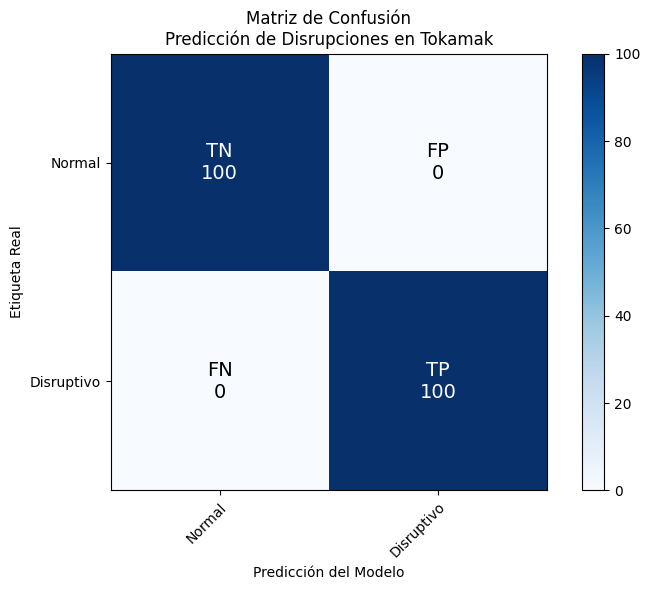

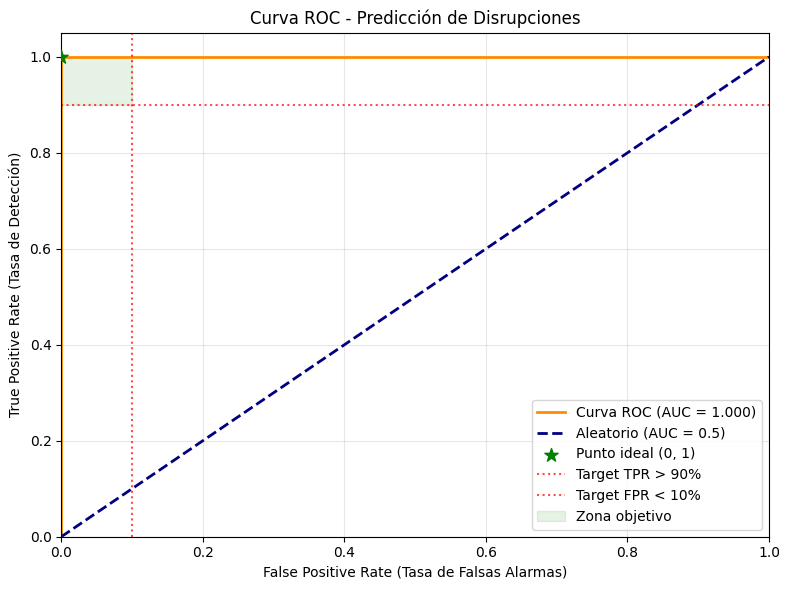

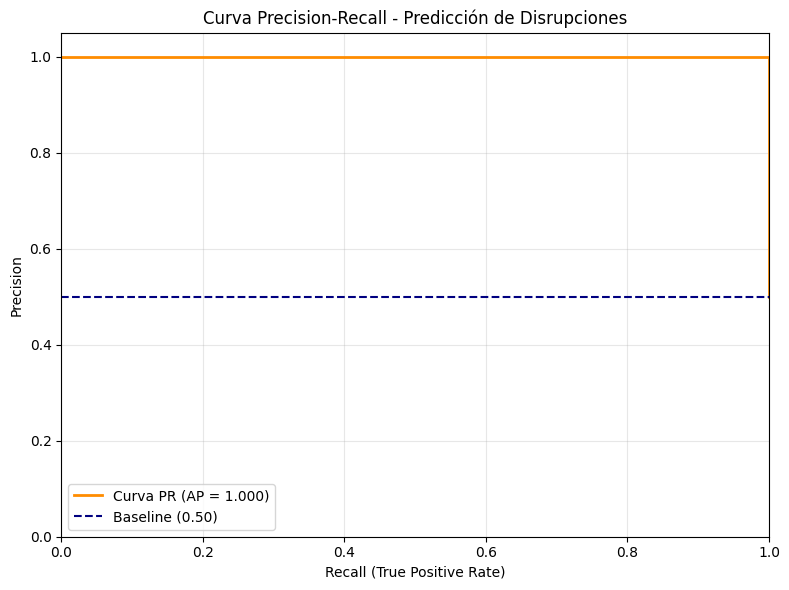

In [10]:
from src.training.evaluate import evaluate_model

# Evaluación en conjunto de validación
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

metrics = evaluate_model(
    model=model,
    data_loader=val_loader,
    device=device,
    save_dir='results',
    plot=True
)